# Performance Evaluation of Python based Data Analytics Frameworks in Summit: Early Experiences

### Smoky Mountains Conference 2020
**Suhas Somnath**<br><br>
**National Center for Computational Sciences**<br>
**Oak Ridge National Laboratory**<br><br>
**08/03/2020**

In [1]:
import sys
import glob
import re
import time
from warnings import warn
from numbers import Number
import numpy as np
import pandas as pd
import matplotlib
from matplotlib.ticker import ScalarFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## String utils

In [2]:
def formatted_str_to_number(str_val, magnitude_names, magnitude_values, separator=' '):
    """
    Takes a formatted string like '4.32 MHz' to 4.32 E+6
    Parameters
    ----------
    str_val : str / unicode
        String value of the quantity. Example '4.32 MHz'
    magnitude_names : Iterable
        List of names of units like ['seconds', 'minutes', 'hours']
    magnitude_values : Iterable
        List of values (corresponding to magnitude_names) that scale the numeric value. Example [1, 60, 3600]
    separator : str / unicode, optional. Default = ' ' (space)
        The text that separates the numeric value and the units.
    Returns
    -------
    number
        Numeric value of the string
    """
    unicode = str
    if not isinstance(separator, (str, unicode)):
        raise TypeError('separator must be a string')
    if not isinstance(magnitude_values, (list, tuple)):
        raise TypeError('magnitude_values must be an Iterable')
    if not np.all([isinstance(_, Number) for _ in magnitude_values]):
        raise TypeError('magnitude_values should contain numbers')
    if len(magnitude_names) != len(magnitude_values):
        raise ValueError('magnitude_names and magnitude_values should be of the same length')

    components = str_val.split(separator)
    if len(components) != 2:
        raise ValueError('String value should be of format "123.45<separator>Unit')

    for unit_name, scaling in zip(magnitude_names, magnitude_values):
        if unit_name == components[1]:
            # Let it raise an exception. Don't catch
            return scaling * float(components[0])

def parse_duration_to_s(time_str):
    return formatted_str_to_number(time_str, ['us', 'ms', 's', 'min'], [1E-6, 1E-3, 1, 60])

def parse_size_to_gb(size_str):
    size_str = size_str.upper()
    return formatted_str_to_number(size_str, ['MB', 'GB', 'TB'], [1/2**10, 2**0, 2**10])

## Plotting utils

In [3]:
mpl.rc('lines', linewidth=2)
mpl.rc('axes', labelsize=16, titlesize=16)
mpl.rc('figure', titlesize=20)
mpl.rc('font', size=14)  # global font size
mpl.rc('legend', fontsize=14, fancybox=True)
mpl.rc('xtick.major', size=6)
mpl.rc('xtick.minor', size=4)
mpl.rcParams['font.size'] = 14.0

def set_tick_font_size(axes, font_size):
    def __set_axis_tick(axis):
        for tick in axis.xaxis.get_major_ticks():
            tick.label.set_fontsize(font_size)
        for tick in axis.yaxis.get_major_ticks():
            tick.label.set_fontsize(font_size)
    if hasattr(axes, '__iter__'):
        for axis in axes:
            __set_axis_tick(axis)
    else:
        __set_axis_tick(axes)
        
def non_sci_log_tick_labels(axis):
    for ax in [axis.xaxis, axis.yaxis]:
        ax.set_major_formatter(ScalarFormatter())
    axis.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axis.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    
def get_line_family_color(ind, num_items, cmap=None):
    if cmap is None:
        cmap = plt.cm.jet
    return cmap(20 + int(ind*225/(num_items-1)))

## Dataframe utils

In [4]:
def stats_from_reps(main_dframe, grouby_col='dframe_size_id'):
    
    def clean_up_stat_df(stat_df, col_name_suffix, cols_to_keep):
        stat_df = stat_df[cols_to_keep]
        stat_df.columns = [x + '_' + col_name_suffix for x in stat_df.columns.values]
        return stat_df
    
    cols_to_keep = list()
    for col_name in main_dframe.columns:
        if col_name.endswith('_time'):
            cols_to_keep.append(col_name)
            
    temp_obj = main_dframe.groupby(by=grouby_col)
    means = temp_obj.mean() 
    errors = temp_obj.std()
    counts = temp_obj.count()
    mins = temp_obj.min()
    maxs = temp_obj.max()
    
    counts = counts[counts.columns[0]]
    counts.name = 'num_runs'
    
    errors = clean_up_stat_df(errors, 'errr', cols_to_keep)
    mins = clean_up_stat_df(mins, 'min', cols_to_keep)
    maxs = clean_up_stat_df(maxs, 'max', cols_to_keep)
            
    return pd.concat([counts, means, errors, mins, maxs], axis=1)

def drop_const_cols(dframe):
    nunique = dframe.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    return dframe.drop(cols_to_drop, axis=1)

## Log parsing functions:

In [5]:
def break_logs_into_runs(raw_lines):
    runs = []
    this_run = []
    for line in raw_lines:
        line = line.replace('\n', '')
        if 'BENCHMARKING ' in line:
            if 'START ' in line:
                this_run = [line]
            if ' END ' in line:
                this_run.append(line)
                runs.append(this_run.copy())
        else:
            if len(line) > 5:
                this_run.append(line)
    return runs

def run_regex(line, template, type_list):
    matchObj = re.match(template, line, re.M|re.I)
    if matchObj:
        return [type_caster(matchObj.group(ind)) for ind, type_caster in zip(range(1,1+len(type_list)),type_list)]
    else:
        return None
    
def parse_until_line(func, logs, offset, verbose=False):
    while offset < len(logs):
        if verbose:
            print('{} looking at: {}'.format(func, logs[offset]))
        ret_val = func(logs[offset])
        if ret_val is None:
            if verbose:
                warn('Ignoring line:\n\t' + logs[offset])
            offset += 1
        else:
            offset += 1
            return offset, ret_val
    raise ValueError('Could not find match for {} in\n\n{}'.format(func, '\n'.join(logs)))

## Line parsing functions:

In [6]:
def parse_inputs(line):
    template = r'Target dataframe size: (.*). package_name: (.*)'
    type_list = [str, str]
    ret_val = run_regex(line, template, type_list)
    if ret_val is not None:
        ret_val = {'dframe_size_id': ret_val[0],
                   'package_name': ret_val[1]}
    return ret_val

def parse_dask_client_stats(line):
    template = r"Client='(.*)' processes=(.*) threads=(.*) memory=(.*)"
    type_list = [str, int, int, str]
    ret_val = run_regex(line, template, type_list)
    if ret_val is not None:
        ret_val = {'Dask_client_address': ret_val[0],
                   'Dask_processes': ret_val[1],
                   'Dask_threads': ret_val[2],
                   'Dask_memory': parse_size_to_gb(ret_val[3])}
    return ret_val

def parse_optional_args(line):
    if 'Optional arguments: ' not in line:
        return None
    line = line.replace('Optional arguments: ', '')
    line = line.replace(', memory=', ' memory=')
    line = line.replace('<Client: ', 'Client=')
    line = line.replace('GB>', 'GB')
    items = line.split(', ')
    kwargs = dict()
    for item in items:
        parts = item.split('=')
        kwargs[parts[0]] = '='.join(parts[1:])
    client_val = kwargs.pop('client', None)
    if client_val is not None:
        client_val = parse_dask_client_stats(client_val)
    if client_val is None:
        kwargs['client'] = None
    else:
        kwargs.update(client_val)
    return kwargs

def parse_package_details(line):
    template = r'Using package: (.*). Version: (.*)'
    type_list = [str, str]
    ret_val = run_regex(line, template, type_list)
    if ret_val is not None:
        ret_val = {'package_handle': ret_val[0],
                   'package_version': ret_val[1]}
    return ret_val

def parse_load_size_time(line):
    template = r'Time to load a (.*) file with (.*): (.*)'
    type_list = [str, str, str]
    ret_val = run_regex(line, template, type_list)
    if ret_val is not None:
        ret_val = {'file_size': parse_size_to_gb(ret_val[0]),
                   'package_name': ret_val[1],
                   'csv_read_time': parse_duration_to_s(ret_val[2])}
    return ret_val
        
def parse_obj_type(line):
    template = r"Dataframe object of type: <class '(.*)'>"
    type_list = [str]
    ret_val = run_regex(line, template, type_list)
    if ret_val is not None:
        ret_val = {'dframe_obj_type': ret_val[0]}
    return ret_val

def parse_default_partitions(line):
    template = r'Dataframe currently has (.*) partitions'
    type_list = [int]
    ret_val = run_regex(line, template, type_list)
    if ret_val is not None:
        ret_val = {'original_partitions': ret_val[0]}
    return ret_val

def parse_reset_partitions(line):
    template = r'Setting number of partitions to: (.*)'
    type_list = [int]
    ret_val = run_regex(line, template, type_list)
    if ret_val is not None:
        ret_val = {'new_partitions': ret_val[0]}
    return ret_val

def parse_read_blocksize(line):
    template = r"read_csv will be given: {'(.*)': '(.*)'}"
    type_list = [str, str]
    ret_val = run_regex(line, template, type_list)
    if ret_val is None:
        return ret_val
    parm, block = ret_val
    num_end = 1
    while num_end < len(block):
        if block[num_end] in '1234567890.':
            num_end += 1
        else:
            block = block[:num_end] + ' ' + block[num_end:].replace('i', '')
            break
    return {parm: block}

def parse_dframe_size(line):
    template = r'Dataframe has (.*) rows and (.*) columns'
    type_list = [int, int]
    ret_val = run_regex(line, template, type_list)
    if ret_val is not None:
        ret_val = {'rows': ret_val[0],
                   'cols': ret_val[1]}
    return ret_val

def parse_num_rows_time(line):
    template = r'Time to calculate number of rows using (.*): (.*)'
    type_list = [str, str]
    ret_val = run_regex(line, template, type_list)
    if ret_val is not None:
        ret_val = {'rows_time': parse_duration_to_s(ret_val[1])}
    return ret_val

def parse_unique_vals_time(line):
    template = r'Time to compute unique values: (.*) using (.*): (.*)'
    type_list = [str, str, str]
    ret_val = run_regex(line, template, type_list)
    if ret_val is not None:
        ret_val = {'unique_vals': ret_val[0],
                   'unique_time': parse_duration_to_s(ret_val[2])}
    return ret_val

def parse_groupby_time(line):
    template = r'Time to compute Groupby using (.*): (.*)'
    type_list = [str, str]
    ret_val = run_regex(line, template, type_list)
    if ret_val is not None:
        ret_val = {'groupby_time': parse_duration_to_s(ret_val[1])}
    return ret_val

def parse_join_indexed_time(line):
    template = r"Time to perform merge using (.*): (.*)"
    type_list = [str, str]
    ret_val = run_regex(line, template, type_list)
    if ret_val is not None:
        ret_val = {'merge_time': parse_duration_to_s(ret_val[1])}
    return ret_val

def parse_run_logs(lines):
    lines = lines[1:-1]
    terms = dict()
    funcs = [parse_inputs, parse_dask_client_stats, parse_optional_args, parse_package_details,
             parse_load_size_time, parse_obj_type, parse_default_partitions, parse_reset_partitions,
             parse_read_blocksize, parse_dframe_size, parse_num_rows_time, parse_unique_vals_time,
             parse_groupby_time, parse_join_indexed_time]
    for line in lines:
        for func in funcs:
            ret_val = func(line)
            if ret_val is not None:
                for key, val in ret_val.items():
                    if key in terms.keys():
                        terms.update({key + '_2': val})
                    else:
                        terms.update({key: val})
    return terms

def parse_results_from_logs(file_paths):
    all_dfs = list()

    for file_path in file_paths:
        with open(file_path) as file_handle:
            raw_lines = file_handle.readlines()

        runs = break_logs_into_runs(raw_lines)    
        all_dfs.append(pd.DataFrame([parse_run_logs(run) for run in runs]))

    return pd.concat(all_dfs)

# Dask-cudf:

In [7]:
dask_cudf_files = glob.glob('dask_cudf_*_gpu.txt')
dask_cudf_files

['dask_cudf_6_gpu.txt',
 'dask_cudf_24_gpu.txt',
 'dask_cudf_12_gpu.txt',
 'dask_cudf_1_gpu.txt',
 'dask_cudf_3_gpu.txt']

In [8]:
dask_cudf_df = parse_results_from_logs(dask_cudf_files)
drop_const_cols(dask_cudf_df).head()

,Dask_client_address,Dask_memory,Dask_processes,Dask_threads,csv_read_time,csv_read_time_2,dframe_size_id,file_size,file_size_2,groupby_time,merge_time,original_partitions,rows,rows_time,unique_time,unique_vals
0,tcp://10.41.0.42:5257,510,6,6,1.58000,0.18097,1G,0.973379,0.099268,23.03,1.07000,4,194346,3.54000,1.57000,260
1,tcp://10.41.0.42:5257,510,6,6,0.19086,0.12523,2.5G,2.500000,0.244502,21.13,2.03000,10,486780,1.30000,1.07000,272
2,tcp://10.41.0.42:5257,510,6,6,0.16149,0.17443,5G,4.920000,0.481689,23.12,3.86000,19,958554,2.24000,1.75000,281
3,tcp://10.41.0.42:5257,510,6,6,0.17910,0.14833,10G,10.140000,1.020000,27.51,5.14000,38,1976400,5.22000,3.16000,292
4,tcp://10.41.0.42:5257,510,6,6,0.17946,0.13898,25G,24.960000,2.500000,47.95,7.10000,93,4865238,9.61000,7.51000,300
5,tcp://10.41.0.42:5257,510,6,6,1.09000,0.07000,1G,0.973379,0.099268,12.83,0.91955,4,194346,0.54905,0.61713,260
6,tcp://10.41.0.42:5257,510,6,6,0.08250,0.07020,2.5G,2.500000,0.244502,15.52,2.03000,10,486780,1.01000,1.03000,272
7,tcp://10.41.0.42:5257,510,6,6,0.07101,0.07181,5G,4.920000,0.481689,19.91,3.13000,19,958554,1.65000,1.78000,281
8,tcp://10.41.0.42:5257,510,6,6,0.07857,0.07032,10G,10.140000,1.020000,25.87,4.33000,38,1976400,3.18000,3.17000,292
9,tcp://10.41.0.42:5257,510,6,6,0.07469,0.07164,25G,24.960000,2.500000,46.98,7.15000,93,4865238,7.38000,7.19000,300


In [9]:
dask_cudf_df.to_csv('./dask_cudf_table_all.csv')

In [9]:
sub_df = dask_cudf_df[dask_cudf_df.dframe_size_id == '1G']
subsub_df = sub_df[sub_df.Dask_threads == 1]
drop_const_cols(subsub_df)

,csv_read_time,csv_read_time_2,groupby_time,merge_time,rows_time,unique_time
0,1.38000,0.10282,20.91,2.55,3.10,1.83
5,0.08348,0.07839,17.68,2.55,1.64,1.45
10,0.07910,0.09688,17.44,2.69,1.58,1.46
15,0.10434,0.09404,17.31,2.76,1.63,1.46
20,0.07883,0.07761,17.36,2.56,1.60,1.46
25,0.07586,0.08737,17.53,2.53,1.59,1.48


In [10]:
col_names = ['csv_read_time', 'unique_time', 'groupby_time', 'merge_time']
file_sizes = ['1G', '2.5G', '5G', '10G', '25G']

num_gpus = dask_cudf_df.Dask_processes.unique()
num_gpus.sort()
num_gpus

array([ 1,  3,  6, 12, 24])

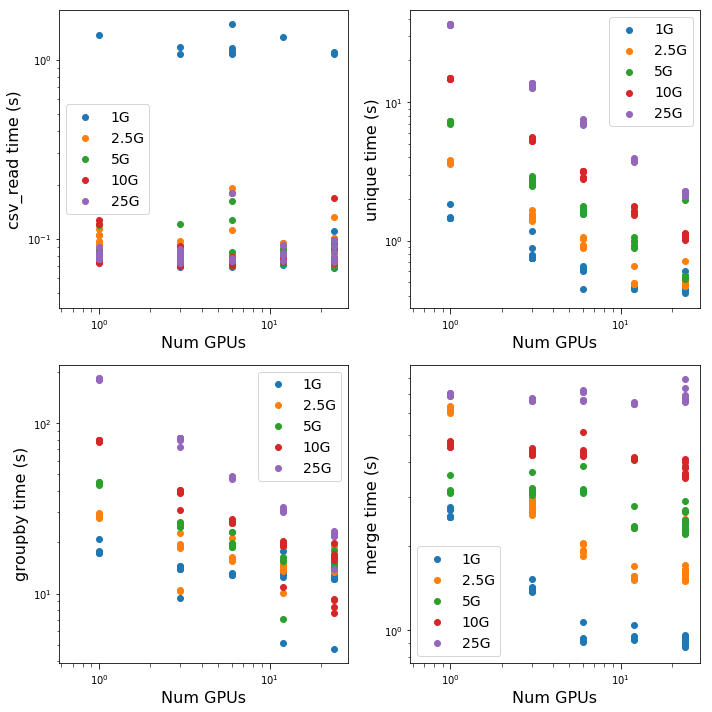

In [184]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for axis, col_name in zip(axes.flat, col_names):
    for this_size in file_sizes:
        x_vec = list()
        y_vec = list()
        for this_gpus in num_gpus:
            sub_df = dask_cudf_df[dask_cudf_df.dframe_size_id == this_size]
            subsub_df = sub_df[sub_df.Dask_threads == this_gpus]
            this_y = list(subsub_df[col_name].values)
            this_x = list(np.ones(len(this_y)) * this_gpus)
            x_vec += this_x
            y_vec += this_y
        axis.scatter(x_vec, y_vec, label=this_size)
        
for axis, col_name in zip(axes.flat, col_names):
    axis.set_ylabel(col_name.replace('_time', ' time (s)'))
    axis.set_xlabel('Num GPUs')
    axis.legend()
    axis.set_xscale('log')
    axis.set_yscale('log')
fig.tight_layout()

In [11]:
dask_cudf_stats = stats_from_reps(dask_cudf_df, grouby_col=['dframe_size_id', 'Dask_threads'])
drop_const_cols(dask_cudf_stats)

num_runs  Dask_processes  csv_read_time  \
dframe_size_id Dask_threads                                            
10G            1                    6               1       0.092238   
               3                   12               3       0.076404   
               6                    6               6       0.090830   
               12                   6              12       0.076818   
               24                  12              24       0.088949   
1G             1                    6               1       0.300268   
               3                   12               3       0.249745   
               6                    6               6       1.014837   
               12                   6              12       0.287390   
               24                  12              24       0.249910   
2.5G           1                    6               1       0.096187   
               3                   12               3       0.085344   
               6                    6               6       0.105242   
               12                   6              12       0.088640   
               24                  12              24       0.095793   
25G            1                    6               1       0.081358   
               3                   12               3       0.079294   
               6                    6               6       0.093043   
               12                   6              12       0.082573   
               24                  12              24       0.081745   
5G             1                    6               1       0.088160   
               3                   12               3       0.083897   
               6                    6               6       0.097423   
               12                   6              12       0.079127   
               24                  12              24       0.078257   

                             csv_read_time_2  file_size  file_size_2  \
dframe_size_id Dask_threads                                            
10G            1                    0.082507  10.140000     1.020000   
               3                    0.076840  10.140000     1.020000   
               6                    0.083127  10.140000     1.020000   
               12                   0.076377  10.140000     1.020000   
               24                   0.077211  10.140000     1.020000   
1G             1                    0.089518   0.973379     0.099268   
               3                    0.072790   0.973379     0.099268   
               6                    0.089985   0.973379     0.099268   
               12                   0.091448   0.973379     0.099268   
               24                   0.084178   0.973379     0.099268   
2.5G           1                    0.080185   2.500000     0.244502   
               3                    0.076204   2.500000     0.244502   
               6                    0.079997   2.500000     0.244502   
               12                   0.080773   2.500000     0.244502   
               24                   0.086902   2.500000     0.244502   
25G            1                    0.081757  24.960000     2.500000   
               3                    0.073851  24.960000     2.500000   
               6                    0.089195  24.960000     2.500000   
               12                   0.075193  24.960000     2.500000   
               24                   0.079132  24.960000     2.500000   
5G             1                    0.077522   4.920000     0.481689   
               3                    0.072210   4.920000     0.481689   
               6                    0.096553   4.920000     0.481689   
               12                   0.074770   4.920000     0.481689   
               24                   0.086457   4.920000     0.481689   

                             groupby_time  merge_time  original_partitions  \
dframe_size_id Dask_threads                                  

# dask-cudf strong scaling

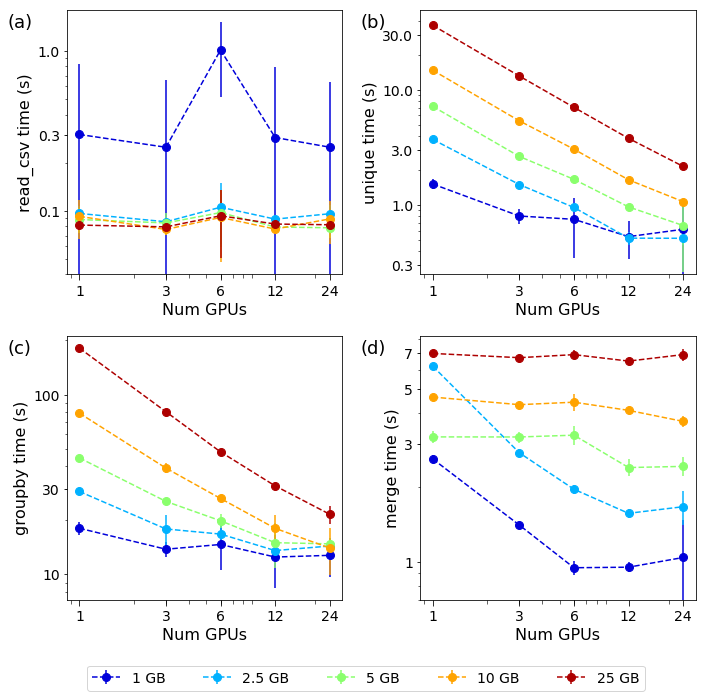

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9.25))

for axis, this_col in zip(axes.flat, col_names):
    for ind, this_size in enumerate(file_sizes):
        sub_df = dask_cudf_stats.loc[this_size]
        x_vals = sub_df.index.values
        y_vals = sub_df[this_col]
        y_err = sub_df[this_col + '_errr']
        axis.errorbar(x_vals, y_vals, yerr=y_err, 
                      marker='o', markersize=8, linestyle='--', linewidth=1.5,
                      color=get_line_family_color(ind, len(file_sizes)), 
                      label=this_size.replace('G', ' GB'))

    if this_col == 'csv_read_time':
        this_col = 'read_csv_time'
    axis.set_ylabel(this_col.replace('_time', ' time (s)'))
    axis.set_xlabel('Num GPUs')
    # axis.legend()
    axis.set_xscale('log')
    axis.set_yscale('log')
    set_tick_font_size(axis, 14)
    non_sci_log_tick_labels(axis)
    
bb = (fig.subplotpars.left, fig.subplotpars.bottom-0.175, 
      fig.subplotpars.right-fig.subplotpars.left,.1)

for axis, y_val, t_val in zip(axes.flat, [1.4, 35, 170, 7], ['a', 'b', 'c', 'd']):
    axis.text(0.4, y_val, '(' + t_val + ')', fontsize=18)
    axis.set_xticks([1, 3, 6, 12, 24])
    
axes.flat[1].set_ylim(bottom=0.25)
axes.flat[3].set_ylim(bottom=0.7)

axes.flat[0].set_yticks([0.1, 0.3, 1])
axes.flat[1].set_yticks([0.3, 1, 3, 10, 30])
axes.flat[2].set_yticks([10, 30, 100])
axes.flat[3].set_yticks([1, 3, 5, 7])

   
fig.tight_layout()
axes.flat[-1].legend(bbox_to_anchor=bb, mode="expand", loc="lower left",
               ncol=5, borderaxespad=0., bbox_transform=fig.transFigure)

fig.savefig('dask_cudf_strong_scaling.png', dpi=300, bbox_inches="tight")

In [24]:
chosen_rows = list()
for this_size, this_gpus in zip(file_sizes, num_gpus):
    chosen_rows.append(dask_cudf_stats.loc[this_size].loc[this_gpus])
    
dcudf_weak = pd.DataFrame(chosen_rows)
dcudf_weak.set_index('Dask_processes', inplace=True)
drop_const_cols(dcudf_weak)

,num_runs,csv_read_time,csv_read_time_2,file_size,file_size_2,groupby_time,merge_time,original_partitions,rows,rows_time,...,csv_read_time_min,groupby_time_min,merge_time_min,rows_time_min,unique_time_min,csv_read_time_max,groupby_time_max,merge_time_max,rows_time_max,unique_time_max
Dask_processes,,,,,,,,,,,,,,,,,,,,,
1.0,6.0,0.300268,0.089518,0.973379,0.099268,18.038333,2.606667,4.0,194346.0,1.856667,...,0.07586,17.31,2.53,1.58,1.45,1.38000,20.91,2.76,3.10,1.83
3.0,12.0,0.085344,0.076204,2.500000,0.244502,17.875000,2.761667,10.0,486780.0,1.617500,...,0.08155,10.33,2.59,1.54,1.38,0.09679,22.52,2.96,1.69,1.67
6.0,6.0,0.097423,0.096553,4.920000,0.481689,19.855000,3.255000,19.0,958554.0,1.781667,...,0.07056,18.72,3.10,1.65,1.57,0.16149,23.12,3.86,2.24,1.78
12.0,6.0,0.076818,0.076377,10.140000,1.020000,18.020000,4.103333,38.0,1976400.0,2.213333,...,0.07378,10.96,4.07,1.72,1.54,0.07854,20.23,4.16,4.15,1.78
24.0,12.0,0.081745,0.079132,24.960000,2.500000,21.577500,6.904167,93.0,4865238.0,2.589167,...,0.07438,13.87,6.55,2.29,2.09,0.09891,23.26,7.92,4.67,2.29


# dask-cudf weak scaling

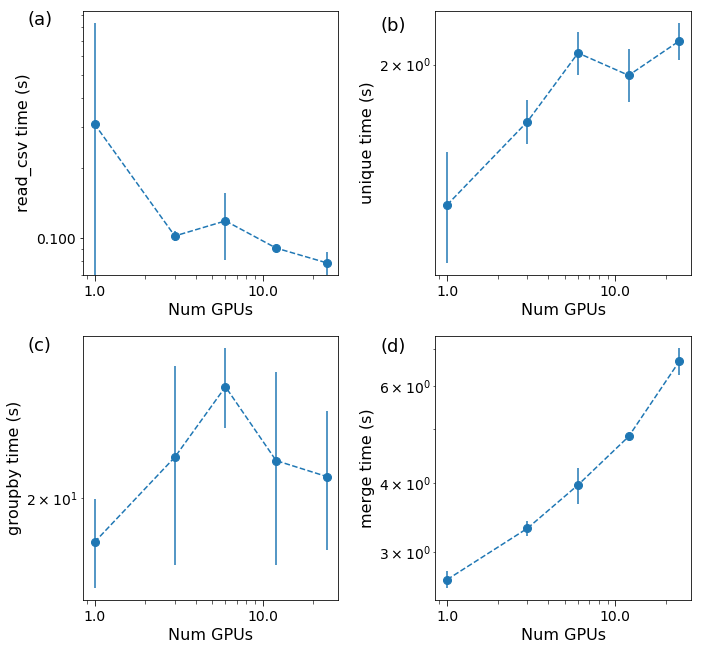

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9.25))

x_vals = sub_df.index.values
actual_size = dcudf_weak['file_size'].values

for axis, this_col in zip(axes.flat, col_names):
    y_vals = dcudf_weak[this_col]
    y_approx = x_vals * y_vals / actual_size # num GPUs x (sec / GBs)
    y_err = dcudf_weak[this_col + '_errr']
    #axis.plot(x_vals, y_vals, '*-')
    # axis.plot(x_vals, y_approx, 'o--')
    axis.errorbar(x_vals, y_approx, yerr=y_err,
                  marker='o', markersize=8, linestyle='--', linewidth=1.5) 
    
    if this_col == 'csv_read_time':
        this_col = 'read_csv_time'
    axis.set_ylabel(this_col.replace('_time', ' time (s)'))
    axis.set_xlabel('Num GPUs')
    axis.set_xticks([1, 3, 6, 12, 24])
    axis.set_xscale('log')
    axis.set_yscale('log')
    set_tick_font_size(axis, 14)
    non_sci_log_tick_labels(axis)

for axis, y_val, t_val in zip(axes.flat, [0.82, 2.12, 25.75, 6.9], ['a', 'b', 'c', 'd']):
    axis.text(0.4, y_val, '(' + t_val + ')', fontsize=18)
    
# fig.suptitle('dask-cudf weak scaling', y=1.05)
    
fig.tight_layout()

fig.savefig('dask_cudf_weak_scaling.png', dpi=300, bbox_inches="tight")

# Dask-dataframe:
Tests need to be performed to get 42 threads per node / worker

In [8]:
dask_df_files = glob.glob('dask_dataframe_*_cores.txt')
dask_df_files

['dask_dataframe_84_cores.txt',
 'dask_dataframe_10_cores.txt',
 'dask_dataframe_5_cores.txt',
 'dask_dataframe_42_cores.txt',
 'dask_dataframe_21_cores.txt',
 'dask_dataframe_168_cores.txt']

In [47]:
dask_df = parse_results_from_logs(dask_df_files)
drop_const_cols(dask_df).head()

,Dask_client_address,Dask_memory,Dask_processes,Dask_threads,csv_read_time,csv_read_time_2,dframe_size_id,file_size,file_size_2,groupby_time,merge_time,original_partitions,rows,rows_time,unique_time,unique_vals
0,tcp://10.41.0.42:5468,None,84,84,0.12350,0.09535,1G,0.973379,0.099268,2.33,4.94,16,194346,1.57,0.06957,260
1,tcp://10.41.0.42:5468,None,84,84,0.14821,0.09328,2.5G,2.500000,0.244502,2.05,5.61,40,486780,1.72,0.10869,272
2,tcp://10.41.0.42:5468,None,84,84,0.20991,0.09880,5G,4.920000,0.481689,2.62,8.44,77,958554,1.88,0.30007,281
3,tcp://10.41.0.42:5468,None,84,84,0.33039,0.16399,10G,10.140000,1.020000,3.20,18.83,159,1976400,3.17,0.36541,292
4,tcp://10.41.0.42:5468,None,84,84,0.10538,0.08578,1G,0.973379,0.099268,1.75,4.62,16,194346,1.00,0.12689,260


In [180]:
dask_df.to_csv('./dask_dataframe_table_all.csv')

In [16]:
num_workers = dask_df.Dask_processes.unique()
num_workers.sort()
num_workers

array([  5,  10,  21,  42,  84, 168])

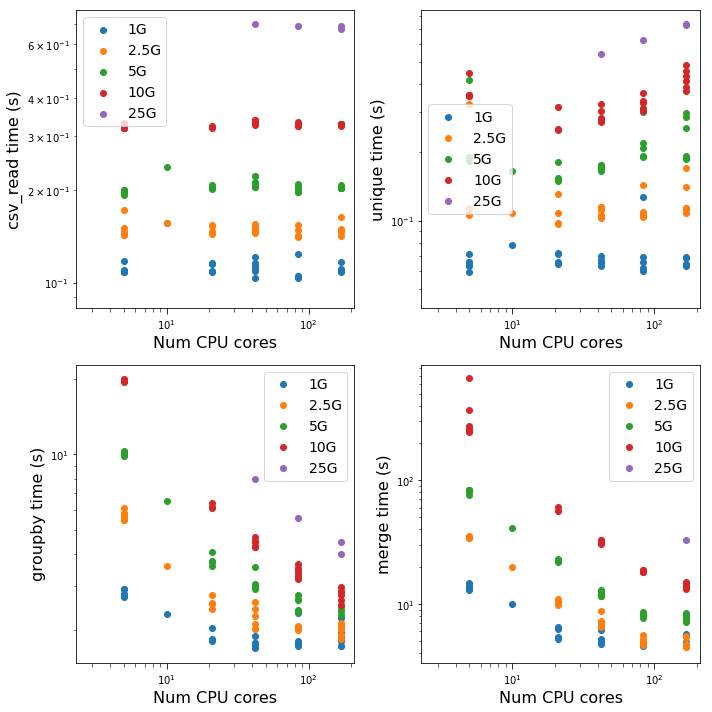

In [185]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for axis, col_name in zip(axes.flat, col_names):
    for ind, this_size in enumerate(file_sizes):
        x_vec = list()
        y_vec = list()
        for this_gpus in num_workers:
            sub_df = dask_df[dask_df.dframe_size_id == this_size]
            subsub_df = sub_df[sub_df.Dask_threads == this_gpus]
            this_y = list(subsub_df[col_name].values)
            this_x = list(np.ones(len(this_y)) * this_gpus)
            x_vec += this_x
            y_vec += this_y
        #print(ind, len(file_sizes))
        axis.scatter(x_vec, y_vec, label=this_size,)
                     #color=get_line_family_color(ind, len(file_sizes)))
        
for axis, col_name in zip(axes.flat, col_names):
    axis.set_ylabel(col_name.replace('_time', ' time (s)'))
    axis.set_xlabel('Num CPU cores')
    axis.legend()
    axis.set_xscale('log')
    axis.set_yscale('log')
fig.tight_layout()

# Dask dataframe worker config:

In [10]:
dask_workers_files = glob.glob('dask_dataframe_42_cores*')
dask_workers_files

['dask_dataframe_42_cores_2_workers.txt',
 'dask_dataframe_42_cores_21_workers.txt',
 'dask_dataframe_42_cores_1_workers.txt',
 'dask_dataframe_42_cores.txt',
 'dask_dataframe_42_cores_6_workers.txt',
 'dask_dataframe_42_cores_2_workers_2.txt',
 'dask_dataframe_42_cores_14_workers.txt']

In [11]:
dask_work = parse_results_from_logs(dask_workers_files)
drop_const_cols(dask_work).head()

,Dask_client_address,Dask_memory,Dask_processes,csv_read_time,csv_read_time_2,dframe_size_id,file_size,file_size_2,groupby_time,merge_time,original_partitions,rows,rows_time,unique_time,unique_vals
0,tcp://10.41.0.41:5235,512.0,2,0.19200,0.15889,1G,0.973379,0.099268,5.47,27.15,16,194346,7.02,0.08388,260
1,tcp://10.41.0.41:5235,512.0,2,0.19649,0.16573,2.5G,2.500000,0.244502,11.28,85.81,40,486780,16.31,0.15080,272
2,tcp://10.41.0.41:5235,512.0,2,0.25860,0.16709,5G,4.920000,0.481689,23.53,180.02,77,958554,30.44,0.25575,281
3,tcp://10.41.0.41:5235,512.0,2,0.41624,0.16174,10G,10.140000,1.020000,43.43,464.19,159,1976400,60.97,0.50450,292
4,tcp://10.41.0.41:5235,512.0,2,0.10957,0.09063,1G,0.973379,0.099268,5.49,28.50,16,194346,6.20,0.07801,260


In [28]:
dask_work.to_csv('./dask_dataframe_workers_on_one_node.csv')

In [12]:
dask_work_stats = stats_from_reps(dask_work, grouby_col=['dframe_size_id', 'Dask_processes'])
drop_const_cols(dask_work_stats)

num_runs  Dask_memory  csv_read_time  \
dframe_size_id Dask_processes                                         
10G            1                      2        512.0       0.324190   
               2                      6        512.0       0.347303   
               6                      6        510.0       0.337800   
               14                     6        504.0       0.325262   
               21                     6        504.0       0.351975   
               42                     6        504.0       0.333595   
1G             1                      3        512.0       0.117257   
               2                      8        512.0       0.127951   
               6                      6        510.0       0.122330   
               14                     6        504.0       0.109663   
               21                     6        504.0       0.116593   
               42                     6        504.0       0.112400   
2.5G           1                      3        512.0       0.147993   
               2                      8        512.0       0.165545   
               6                      6        510.0       0.158943   
               14                     6        504.0       0.144138   
               21                     6        504.0       0.165895   
               42                     6        504.0       0.149442   
25G            6                      3        510.0       0.717277   
               21                     1        504.0       0.760000   
               42                     1        504.0       0.698550   
5G             1                      3        512.0       0.201843   
               2                      7        512.0       0.217894   
               6                      6        510.0       0.216892   
               14                     6        504.0       0.207758   
               21                     6        504.0       0.211572   
               42                     6        504.0       0.213000   

                               csv_read_time_2  file_size  file_size_2  \
dframe_size_id Dask_processes                                            
10G            1                      0.113490  10.140000     1.020000   
               2                      0.124852  10.140000     1.020000   
               6                      0.120642  10.140000     1.020000   
               14                     0.113552  10.140000     1.020000   
               21                     0.117153  10.140000     1.020000   
               42                     0.203850  10.140000     1.020000   
1G             1                      0.088377   0.973379     0.099268   
               2                      0.109567   0.973379     0.099268   
               6                      0.103113   0.973379     0.099268   
               14                     0.088553   0.973379     0.099268   
               21                     0.095068   0.973379     0.099268   
               42                     0.089802   0.973379     0.099268   
2.5G           1                      0.093310   2.500000     0.244502   
               2                      0.106607   2.500000     0.244502   
               6                      0.101813   2.500000     0.244502   
               14                     0.090508   2.500000     0.244502   
               21                     0.096383   2.500000     0.244502   
               42                     0.110162   2.500000     0.244502   
25G            6                      0.165170  24.960000     2.500000   
               21                     0.155950  24.960000     2.500000   
               42                     0.202370  24.960000     2.500000   
5G             1                      0.099670   4.920000     0.481689   
               2                      0.110066   4.920000     0.481689   
               6                      0.113887   4.920000     0.481689   
               14                     0.100483 

In [13]:
col_names = ['csv_read_time', 'unique_time', 'groupby_time', 'merge_time']
file_sizes = ['1G', '2.5G', '5G', '10G', '25G']

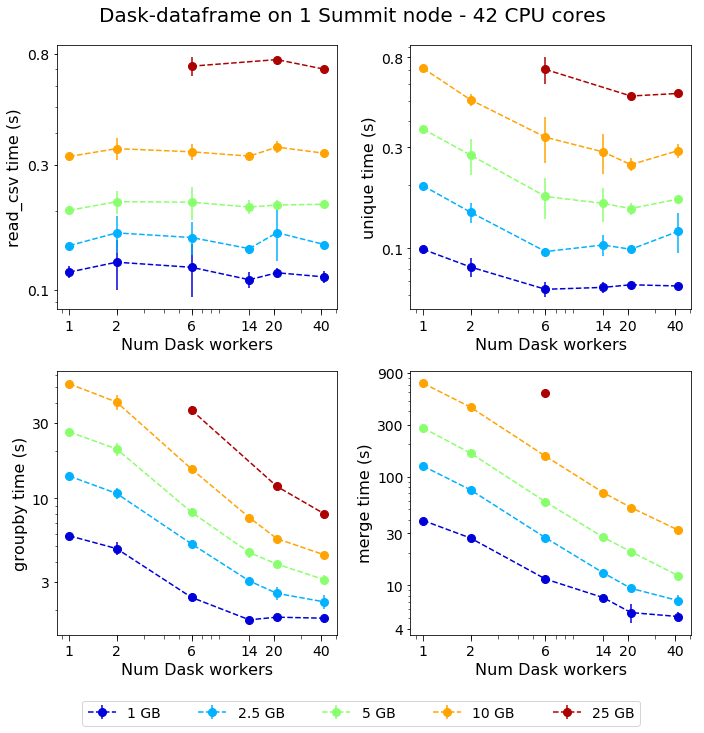

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9.25))

for axis, this_col in zip(axes.flat, col_names):
    for ind, this_size in enumerate(file_sizes):
        sub_df = dask_work_stats.loc[this_size]
        x_vals = sub_df.index.values
        y_vals = sub_df[this_col]
        y_err = sub_df[this_col + '_errr']
        axis.errorbar(x_vals, y_vals, yerr=y_err, 
                      marker='o', markersize=8, linestyle='--', linewidth=1.5,
                      color=get_line_family_color(ind, len(file_sizes)), 
                      label=this_size.replace('G', ' GB'))

    if this_col == 'csv_read_time':
        this_col = 'read_csv_time'
    axis.set_ylabel(this_col.replace('_time', ' time (s)'))
    axis.set_xlabel('Num Dask workers')
    # axis.legend()
    axis.set_xscale('log')
    axis.set_yscale('log')
    set_tick_font_size(axis, 14)
    non_sci_log_tick_labels(axis)
    
bb = (fig.subplotpars.left, fig.subplotpars.bottom-0.175, 
      fig.subplotpars.right-fig.subplotpars.left,.1)

for axis, y_val, t_val in zip(axes.flat, [1.4, 35, 170, 7], ['a', 'b', 'c', 'd']):
    pass
    #axis.text(0.4, y_val, '(' + t_val + ')', fontsize=18)
    axis.set_xticks([1, 2, 6, 14, 20, 40])
    
axes.flat[0].set_yticks([0.1, 0.3, 0.8])
axes.flat[1].set_yticks([0.1, 0.3, 0.8])
axes.flat[2].set_yticks([3, 10, 30])
axes.flat[3].set_yticks([4, 10, 30, 100, 300, 900])

fig.suptitle('Dask-dataframe on 1 Summit node - 42 CPU cores', y=1.03)

   
fig.tight_layout()
axes.flat[-1].legend(bbox_to_anchor=bb, mode="expand", loc="lower left",
               ncol=5, borderaxespad=0., bbox_transform=fig.transFigure)

fig.savefig('dask_dataframe_workers.png', dpi=300, bbox_inches="tight")

# cuDF

In [48]:
cudf_files = glob.glob('cudf_benchmarking.o*')
cudf_files

['cudf_benchmarking.o260612', 'cudf_benchmarking.o260594']

In [49]:
cudf_df = parse_results_from_logs(cudf_files)
drop_const_cols(cudf_df).head()

,client,csv_read_time,csv_read_time_2,dframe_size_id,file_size,file_size_2,groupby_time,merge_time,rows,rows_time,unique_time,unique_vals
0,None,2.1500,0.09517,1G,0.973379,0.099268,5.39,0.27425,194346,0.000436,0.002200,260
1,None,2.2200,0.17342,2.5G,2.500000,0.244502,1.58,0.16013,486780,0.000334,0.003220,272
2,None,4.1900,0.42135,5G,4.920000,0.481689,1.87,0.24093,958554,0.000320,0.005050,281
3,None,0.6893,0.06496,1G,0.973379,0.099268,1.16,0.09358,194346,0.000302,0.000962,260
4,None,1.6300,0.11551,2.5G,2.500000,0.244502,1.70,0.15170,486780,0.000302,0.003230,272


In [181]:
cudf_df.to_csv('./cudf_table_all.csv')

# Pandas:

In [50]:
pandas_files = glob.glob('pandas_benchmarking.o*')
pandas_files

['pandas_benchmarking.o260589']

In [51]:
pandas_df = parse_results_from_logs(pandas_files)
drop_const_cols(pandas_df).head()

,client,csv_read_time,csv_read_time_2,dframe_size_id,file_size,file_size_2,groupby_time,merge_time,rows,rows_time,unique_time,unique_vals
0,None,10.48,1.09,1G,0.973379,0.099268,1.06,0.02549,194346,0.000011,0.00170,260
1,None,26.08,2.62,2.5G,2.500000,0.244502,3.57,0.05450,486780,0.000014,0.00270,272
2,None,50.81,5.10,5G,4.920000,0.481689,5.32,0.10258,958554,0.000016,0.00496,281
3,None,103.72,13.34,10G,10.140000,1.020000,10.77,0.20555,1976400,0.000017,0.00971,292
4,None,255.31,31.81,25G,24.960000,2.500000,26.42,0.49746,4865238,0.000017,0.02373,300


In [182]:
pandas_df.to_csv('./pandas_table_all.csv')

# Figure 2 - package comparison:

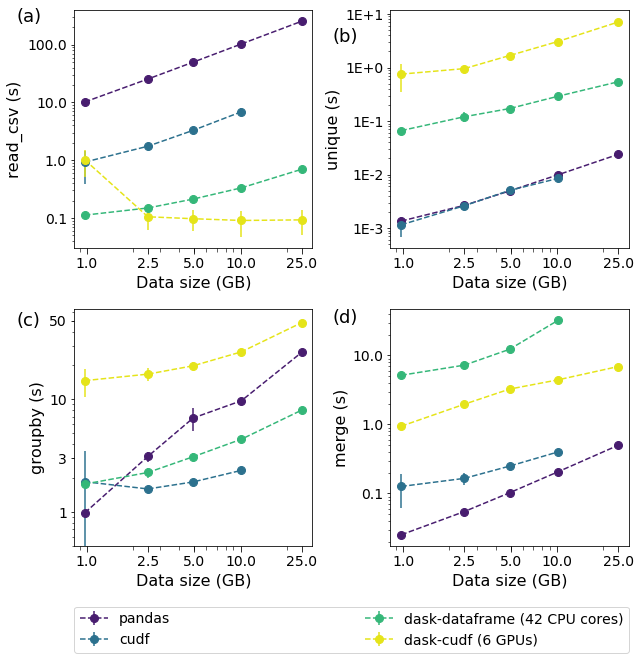

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 8.5))
for ind, dframe, pack_name in zip(list(range(4)),
                                  [pandas_df, cudf_df, 
                                   dask_df[dask_df.Dask_threads == 42], 
                                   dask_cudf_df[dask_cudf_df.Dask_threads == 6]],
                                  ['pandas', 'cudf', 'dask-dataframe (42 CPU cores)', 'dask-cudf (6 GPUs)']):
        
    dframe_stats = stats_from_reps(dframe, grouby_col='file_size')
    
    for axis, col_name in zip(axes.flat, ['csv_read_time', 'unique_time', 'groupby_time', 'merge_time']):
        
        axis.errorbar(dframe_stats.index.values, 
                      dframe_stats[col_name].values, 
                      yerr=dframe_stats[col_name + '_errr'].values, 
                      fmt='o--', markersize=8, label=pack_name, linewidth=1.5,#) # mec='black', mfc='black'
                      color=get_line_family_color(ind, 4, cmap=plt.cm.viridis))
        
        if col_name == 'csv_read_time':
            col_name = 'read_csv_time'

        axis.set_xscale('log')
        axis.set_yscale('log')
        axis.set_ylabel(col_name.replace('_time', '') + ' (s)')
        axis.set_xlabel('Data size (GB)')
        set_tick_font_size(axis, 14)
        non_sci_log_tick_labels(axis)
        axis.set_xticks([1, 2.5, 5, 10, 25])

#axes.flat[0].text(0.33, 230, '(a)', fontsize=18)
##axes.flat[1].text(0.33, 20, '(b)', fontsize=18)
#axes.flat[2].text(0.33, 200, '(c)', fontsize=18)
#axes.flat[3].text(0.33, 220, '(d)', fontsize=18)
    
for axis, y_val, t_val in zip(axes.flat, [250, 3, 45, 30], ['a', 'b', 'c', 'd']):
    axis.text(0.35, y_val, '(' + t_val + ')', fontsize=18)
    
fig.tight_layout()

bb = (fig.subplotpars.left, fig.subplotpars.bottom-0.175, 
      fig.subplotpars.right-fig.subplotpars.left, .1)

axes.flat[3].legend(bbox_to_anchor=bb, mode="expand", loc="lower left",
                    ncol=2, borderaxespad=0., bbox_transform=fig.transFigure) 

axes.flat[2].set_ylim(bottom=0.5)

axes.flat[0].set_yticks([0.1, 1, 10, 100])
axes.flat[1].set_yticks([0.001, 0.01, 0.1, 1, 10])
axes.flat[1].set_yticklabels(['1E-3', '1E-2', '1E-1', '1E+0', '1E+1'])
axes.flat[2].set_yticks([1, 3, 10, 50])

fig.savefig('dask_cudf_packages_comparison.png', dpi=300, bbox_inches="tight")